# Time series analysis as supervised learning

The remaining parts of the project will build models for time series data using Keras.

We will be using the mortgage affordability provided by Zillow https://www.zillow.com/research/data/ we have seen previously.

The project repository includes the data and utility functions to load and plot it

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import affordability_lib.utils as utils

afford_df = utils.get_affordability_df()
afford_df.head(10)

,RegionID,RegionName,SizeRank,1979-03,1979-06,1979-09,1979-12,1980-03,1980-06,1980-09,...,2014-12,2015-03,2015-06,2015-09,2015-12,2016-03,2016-06,2016-09,2016-12,2017-03
324,394913,"New York, NY",1,0.261700,0.278316,0.284399,0.319438,0.379845,0.318970,0.337586,...,0.241961,0.240494,0.247387,0.245957,0.249606,0.241544,0.239503,0.240021,0.265376,0.269264
325,753899,"Los Angeles-Long Beach-Anaheim, CA",2,0.357694,0.388161,0.401762,0.459422,0.541508,0.464528,0.486750,...,0.383162,0.382531,0.396277,0.395686,0.402116,0.393042,0.390708,0.386895,0.430334,0.433476
326,394463,"Chicago, IL",3,0.261928,0.276790,0.276248,0.309709,0.353099,0.299344,0.295616,...,0.134913,0.134063,0.139074,0.137962,0.138784,0.134412,0.133701,0.132856,0.147025,0.149054
327,394514,"Dallas-Fort Worth, TX",4,0.301131,0.328453,0.340857,0.386321,0.452818,0.376912,0.394715,...,0.118163,0.117663,0.124935,0.128167,0.133517,0.131539,0.133219,0.135142,0.149861,0.152387
328,394974,"Philadelphia, PA",5,0.204333,0.215107,0.219247,0.247690,0.295396,0.248018,0.260259,...,0.141915,0.139100,0.142831,0.141625,0.142089,0.137387,0.135599,0.135064,0.148746,0.148559
329,394692,"Houston, TX",6,0.243178,0.265630,0.268049,0.294382,0.342770,0.291661,0.292763,...,0.112149,0.113520,0.118255,0.119155,0.122370,0.120863,0.120717,0.120675,0.132078,0.130511
330,395209,"Washington, DC",7,0.254252,0.264869,0.277353,0.314773,0.373035,0.319475,0.337635,...,0.174821,0.173381,0.178910,0.177032,0.178584,0.172367,0.169965,0.168010,0.185774,0.186239
331,394856,"Miami-Fort Lauderdale, FL",8,0.267852,0.284229,0.287053,0.332037,0.392403,0.334098,0.360938,...,0.181766,0.183585,0.194088,0.197580,0.203430,0.197855,0.198292,0.199508,0.221129,0.222176
332,394347,"Atlanta, GA",9,0.248301,0.264578,0.271742,0.312490,0.371988,0.307385,0.322451,...,0.113326,0.113214,0.117454,0.118066,0.120754,0.117895,0.117187,0.116937,0.130104,0.131081
333,394404,"Boston, MA",10,0.222021,0.237248,0.239940,0.276893,0.316496,0.271210,0.285134,...,0.212892,0.210786,0.216809,0.217371,0.221722,0.215844,0.214103,0.212644,0.236357,0.239656


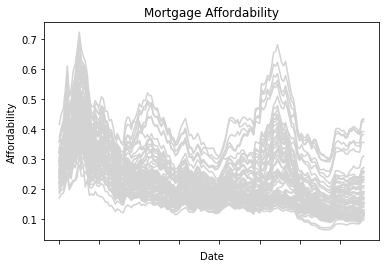

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
utils.plot_affordability_series(afford_df)
plt.show()

## Getting data ready

We will build models that forecast mortgage one-year-out affordability based on the previous 4 years of affordability values. To obtain data for model building we provide the class `TSExampleGenerator` in the `affordability_lib.utils` module. This class does a bunch of things so let's take a look by parts.

First, let's initialize the object. Here, we will set important parameters for our model building. We'll explain the parameters below

In [3]:
from affordability_lib.utils import TSExampleGenerator
example_generator_factory = TSExampleGenerator(afford_df, horizon=4, n_prediction_years=4,
                                      n_test_quarters = 4, n_val_quarters=4,
                                      normalize=True)


The parameters we pass have the following purpose:
- `afford_df`: the affordability data frame
- `horizon=4`: how far from the last observed timepoint do we make predictions, since we are making one-year-out predictions, we have a 4 quarter horizon
- `n_prediction_years`: how many years of data we use to make predictions, here we use 4 years, which gives us 16 total time points to use for predictions. Therefore, we have sequences of length 16, to make predictions of sequences of length 1
- `n_test_quarters`: we split the dataset into train, validation and test, here we specify that the **last four quarters** of data are to be used as targets for testing
- `n_val_quarters`: here we set that the four quarters preceeding the quarters above will be used as targets for validation, all the remaning data will be used for training
- `normalize`: standardize timeseries for each region by centering and scaling using region-specific mean and standard deviation. These parameters are computed from the training portion of the sequences only.

Once we have the object above we can get generators for the training, validation and testing portions of the dataset as follows:

In [4]:
# get generator for testing portion of dataset
test_generator, num_test_steps = example_generator_factory.get_test_gen(batchsize=20)
print(test_generator)
print(num_test_steps)

<generator object _example_generator at 0x000001CB59A65678>
15


The above states that `test_generator` is a python generator. These are objects we can use in iterations using the `next` keyword. For example, to get a batch of 20 test sequences I can do the following:

In [6]:
X, y = next(test_generator)
print(X.shape)
print(y.shape)

(20, 16, 1)
(20,)


Note that the shape of `X` has three dimensions because sequence models in keras require it. The first dimension is the number of sequences, the second dimension the number of steps in the sequence (time), and the third dimension the dimensionality of the observations at each timestep (here 1 since we only observe affordability, in other situations this could be a multidimensional vector).


The way this code is designed, we can call the `next` keyword on these generators infinitely as it is easier to use within keras that way. The `num_test_steps` returned above is used to ensure that we generate enough examples to cycle through at least once through the corresponding portion of the dataset. For instance, the following loop generates all test examples in the dataset.

In [7]:
for i in range(num_test_steps):
    X, y = next(test_generator)

## Baseline model

To get a sense of the problem, let's use a baseline model that uses average mortgage affordability over the previous four years to predict one-year-out affordability. Let's try this model on the validation dataset and compute it's median absolute error.

In [22]:
import numpy as np

def evaluate_naive():
    batch_maes = []
    gen, num_steps = example_generator_factory.get_val_gen(batchsize=20)
    for step in range(num_steps):
        X, y = next(gen)
        yhat = np.mean(X, axis=1)
        mae = np.median(np.abs(y - yhat))
        batch_maes.append(mae)
    return batch_maes

naive_maes = evaluate_naive()
print(np.mean(naive_maes))
print(np.std(naive_maes))

0.27454311314151586
0.05348667369435827


## Model building

Let's build a few models for this task using keras. For all of these use `RMSprop` as the gradient descent algorithm, and `median absolute error` as the loss function. For each of the model plot training and validation error across epochs and comment on their behavior. Is the model learning anything, is it overfitting, how stable is it, etc. For each model, report median absolute error on the validation set.

### Model 1: Linear Regression 

Train a linear regression model using Keras for this task.

- Recall that for linear regression we want to build a model

$$
f = Xw + b
$$ 

where in this case, $X$ will be a matrix with 16 columns, corresponding to the values of affordability for the previous four years.

The first layer in your network will be a `Flatten` layer since this is not a sequence model. This is true of the next two models as well. 

The general structure of your models will be as follows:

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, Flatten, SimpleRNN, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

In [11]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(526, activation='relu'))
model.add(Dense(1, activation='linear'))

rmsprop = RMSprop(lr=0.001)

model.compile(optimizer=rmsprop, loss='mae', metrics=['accuracy'])

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 2s 4ms/step - loss: 0.1391 - acc: 0.0000e+00 - val_loss: 0.2215 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 2s 3ms/step - loss: 0.1014 - acc: 0.0000e+00 - val_loss: 0.2248 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0840 - acc: 0.0000e+00 - val_loss: 0.2208 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0761 - acc: 0.0000e+00 - val_loss: 0.1603 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0713 - acc: 0.0000e+00 - val_loss: 0.1774 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0684 - acc: 0.0000e+00 - val_loss: 0.1283 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0660 - acc: 0.0000e+00 - val_loss: 0.2085 - val_acc: 0.0000e+00
Epoch 8/20
540/540 [

In [13]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

rmsprop = RMSprop()

model.compile(optimizer=rmsprop, loss='mae', metrics=['accuracy'])

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 2s 4ms/step - loss: 0.1085 - acc: 0.0000e+00 - val_loss: 0.2121 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0933 - acc: 0.0000e+00 - val_loss: 0.2250 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0848 - acc: 0.0000e+00 - val_loss: 0.0878 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0787 - acc: 0.0000e+00 - val_loss: 0.1879 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0745 - acc: 0.0000e+00 - val_loss: 0.0965 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0709 - acc: 0.0000e+00 - val_loss: 0.1554 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0680 - acc: 0.0000e+00 - val_loss: 0.1844 - val_acc: 0.0000e+00
Epoch 8/20
540/540 [

In [14]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(526, activation='relu'))
model.add(Dense(1, activation='linear'))

rmsprop = RMSprop()

model.compile(optimizer=rmsprop, loss='mae', metrics=['accuracy'])

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 3s 5ms/step - loss: 0.1504 - acc: 0.0000e+00 - val_loss: 0.2238 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 2s 4ms/step - loss: 0.1042 - acc: 0.0000e+00 - val_loss: 0.2008 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0866 - acc: 0.0000e+00 - val_loss: 0.2449 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0776 - acc: 0.0000e+00 - val_loss: 0.2048 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0724 - acc: 0.0000e+00 - val_loss: 0.2097 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0690 - acc: 0.0000e+00 - val_loss: 0.2159 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0661 - acc: 0.0000e+00 - val_loss: 0.2522 - val_acc: 0.0000e+00
Epoch 8/20
540/540 [

## Conclusion

- It's better to use default than setting learning rate in RMSprop optimizer:
        For example: RMSprop() is better than RMSprop(lr=0.001) 
- For one layer NN, increasing hidden layer unit number doesn't improve results:  

In [16]:
print('Training -----------')

for step in range(num_train_steps):
    X_train, y_train = next(train_gen)
    #print(X_train.shape[1:])
    cost = model.train_on_batch(X_train, y_train)
    if step % 100 == 0:
        print('train cost: ', cost)

Training -----------
train cost:  [0.035631772, 0.0]
train cost:  [0.040394984, 0.0]
train cost:  [0.06346612, 0.0]
train cost:  [0.041374695, 0.0]
train cost:  [0.033819202, 0.0]
train cost:  [0.03293246, 0.0]


In [17]:
print('Evaluating -----------')

for step in range(num_val_steps):
    X_test, y_test = next(val_gen)

    score = model.evaluate(X_test, y_test,verbose=1)
    print('Evaluation Score: ', score)

Evaluating -----------
20/20 [==============================] - 0s 100us/step
Evaluation Score:  [0.12623417377471924, 0.0]
20/20 [==============================] - 0s 150us/step
Evaluation Score:  [0.11337611824274063, 0.0]
20/20 [==============================] - 0s 250us/step
Evaluation Score:  [0.09064967930316925, 0.0]
20/20 [==============================] - 0s 227us/step
Evaluation Score:  [0.13926276564598083, 0.0]
20/20 [==============================] - 0s 150us/step
Evaluation Score:  [0.12623417377471924, 0.0]
20/20 [==============================] - 0s 100us/step
Evaluation Score:  [0.11337611824274063, 0.0]
20/20 [==============================] - 0s 50us/step
Evaluation Score:  [0.09064967930316925, 0.0]
20/20 [==============================] - 0s 100us/step
Evaluation Score:  [0.13926276564598083, 0.0]
20/20 [==============================] - 0s 150us/step
Evaluation Score:  [0.12623417377471924, 0.0]
20/20 [==============================] - 0s 100us/step
Evaluation Sco

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


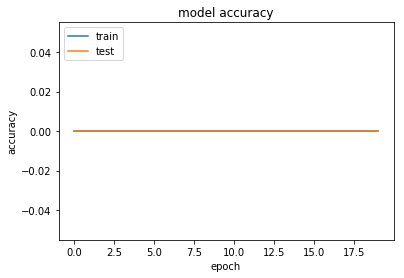

In [19]:
# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

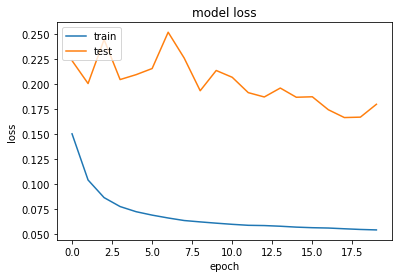

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 2: Single Layer Feed-Forward Neural Network

Train a single layer feed forward neural network using Keras.

Don't worry about tuning parameters yet (i.e., the number of units in the hidden layer units). Choose a number and go with it.


In [32]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(768, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, activation='linear'))

#sgd = SGD(lr=0.01)
sgd = SGD()
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 4s 7ms/step - loss: -18.0173 - acc: 0.0000e+00 - val_loss: -16.6599 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.8421 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.8421 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.8421 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.8167 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.7553 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.6599 - val_acc: 0.0

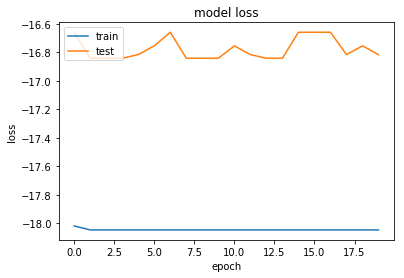

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(768, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, activation='linear'))

sgd = SGD(lr=0.001)
#sgd = SGD()
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 4s 7ms/step - loss: -18.0173 - acc: 0.0000e+00 - val_loss: -16.7553 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.8167 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 2s 5ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.7553 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 2s 5ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.6599 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.8421 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.8167 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 2s 4ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -16.6599 - val_acc: 0.0

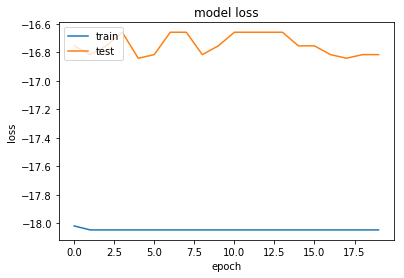

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(768, kernel_initializer='uniform', activation='relu'))
model.add(Dense(384, activation='relu', kernel_initializer='uniform'))
model.add(Dense(256, activation='selu', kernel_initializer='uniform'))
model.add(Dense(128, activation='selu', kernel_initializer='uniform'))
model.add(Dense(64, activation='selu', kernel_initializer='uniform'))
model.add(Dense(1, activation='linear'))

#sgd = SGD(lr=0.01)
sgd = SGD()
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 12s 23ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -14.2716 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 10s 19ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -14.0301 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 12s 22ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -14.0301 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 11s 21ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -14.0301 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 10s 19ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -14.0301 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 11s 21ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -13.8975 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 11s 21ms/step - loss: -18.0453 - acc: 0.0000e+00 - val_loss: -13.8975 

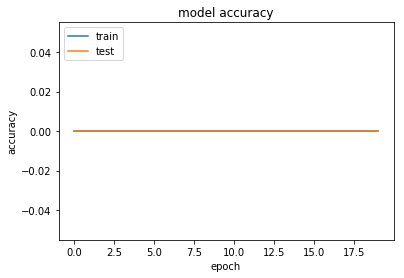

In [30]:
# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

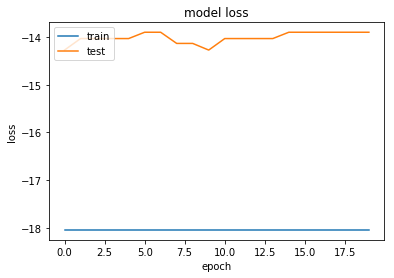

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conclusion

- From the above testing results, the Feed-Forward Neural Network (FFNN) is not good at time series data
- Adding more layers doesn't improve accuracy.

### Model 3: Deep Neural Network

Train a neural network with one or more layers for this task. 

Here, try tuning parameters (the number of hidden layers, and the number of units per layer). Use MAE on validation set as a guide.

In [46]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

#rmsprop = RMSprop(lr=0.001)
rmsprop = RMSprop()
model.compile(optimizer=rmsprop, loss='mae', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 5s 9ms/step - loss: 0.1082 - acc: 0.0000e+00 - val_loss: 0.3143 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 2s 5ms/step - loss: 0.0862 - acc: 0.0000e+00 - val_loss: 0.2737 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0790 - acc: 0.0000e+00 - val_loss: 0.2085 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0740 - acc: 0.0000e+00 - val_loss: 0.1395 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0706 - acc: 0.0000e+00 - val_loss: 0.1793 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0683 - acc: 0.0000e+00 - val_loss: 0.1306 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 3s 5ms/step - loss: 0.0667 - acc: 0.0000e+00 - val_loss: 0.1660 - val_acc: 0.0000e+00
Epoch 8/20
540/540 [

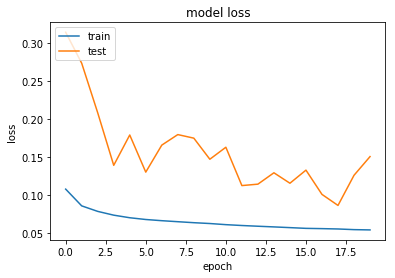

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(738, activation='relu'))
model.add(Dense(1, activation='linear'))

#rmsprop = RMSprop(lr=0.001)
rmsprop = RMSprop()
model.compile(optimizer=rmsprop, loss='mae', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 5s 9ms/step - loss: 0.1513 - acc: 0.0000e+00 - val_loss: 0.1810 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - ETA: 0s - loss: 0.1011 - acc: 0.0000e+0 - 3s 5ms/step - loss: 0.1010 - acc: 0.0000e+00 - val_loss: 0.1956 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 3s 5ms/step - loss: 0.0827 - acc: 0.0000e+00 - val_loss: 0.2200 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0746 - acc: 0.0000e+00 - val_loss: 0.2165 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0701 - acc: 0.0000e+00 - val_loss: 0.2409 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 3s 5ms/step - loss: 0.0675 - acc: 0.0000e+00 - val_loss: 0.1982 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 3s 5ms/step - loss: 0.0653 - acc: 0.0000e+00 - val_loss: 0.2097 

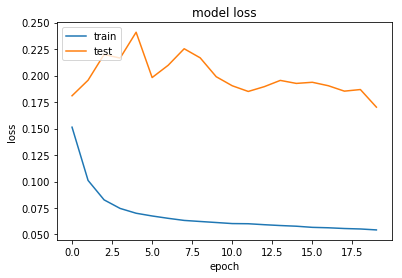

In [49]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(738, activation='relu'))
model.add(Dense(526, activation='relu'))
model.add(Dense(438, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

rmsprop = RMSprop(lr=0.001)
#rmsprop = RMSprop()
model.compile(optimizer=rmsprop, loss='mae', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 22s 41ms/step - loss: 0.1819 - acc: 0.0000e+00 - val_loss: 0.1398 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 21s 39ms/step - loss: 0.1074 - acc: 0.0000e+00 - val_loss: 0.1347 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 21s 39ms/step - loss: 0.0940 - acc: 0.0000e+00 - val_loss: 0.1645 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 24s 44ms/step - loss: 0.0855 - acc: 0.0000e+00 - val_loss: 0.1622 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 22s 41ms/step - loss: 0.0769 - acc: 0.0000e+00 - val_loss: 0.1866 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 25s 46ms/step - loss: 0.0710 - acc: 0.0000e+00 - val_loss: 0.1558 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 24s 45ms/step - loss: 0.0667 - acc: 0.0000e+00 - val_loss: 0.1351 - val_acc: 0.0000e+00
Epoch 

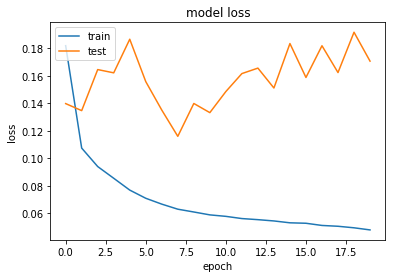

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(738, activation='relu'))
model.add(Dense(526, activation='relu'))
model.add(Dense(438, activation='selu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

#rmsprop = RMSprop(lr=0.001)
rmsprop = RMSprop()
model.compile(optimizer=rmsprop, loss='mae', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 23s 42ms/step - loss: 0.1942 - acc: 0.0000e+00 - val_loss: 0.2702 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 20s 37ms/step - loss: 0.1076 - acc: 0.0000e+00 - val_loss: 0.2152 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 21s 39ms/step - loss: 0.0959 - acc: 0.0000e+00 - val_loss: 0.1850 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 22s 41ms/step - loss: 0.0875 - acc: 0.0000e+00 - val_loss: 0.1389 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 21s 38ms/step - loss: 0.0818 - acc: 0.0000e+00 - val_loss: 0.1822 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 22s 40ms/step - loss: 0.0772 - acc: 0.0000e+00 - val_loss: 0.2047 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 22s 41ms/step - loss: 0.0718 - acc: 0.0000e+00 - val_loss: 0.1995 - val_acc: 0.0000e+00
Epoch 

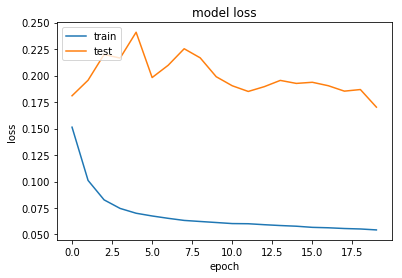

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(738, activation='relu'))
model.add(Dense(526, activation='relu'))
model.add(Dense(1, activation='linear'))

rmsprop = RMSprop()
model.compile(optimizer=rmsprop, loss='mae', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 16s 30ms/step - loss: 0.1504 - acc: 0.0000e+00 - val_loss: 0.1232 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 13s 24ms/step - loss: 0.0943 - acc: 0.0000e+00 - val_loss: 0.2053 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 14s 26ms/step - loss: 0.0814 - acc: 0.0000e+00 - val_loss: 0.1571 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 14s 26ms/step - loss: 0.0742 - acc: 0.0000e+00 - val_loss: 0.1022 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 16s 29ms/step - loss: 0.0701 - acc: 0.0000e+00 - val_loss: 0.1245 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 16s 30ms/step - loss: 0.0675 - acc: 0.0000e+00 - val_loss: 0.1607 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 17s 32ms/step - loss: 0.0646 - acc: 0.0000e+00 - val_loss: 0.1350 - val_acc: 0.0000e+00
Epoch 

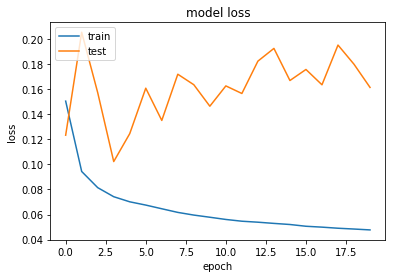

In [54]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
model = Sequential()
model.add(Flatten(input_shape=(16,1)))
model.add(Dense(738, activation='relu'))
model.add(Dense(526, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

rmsprop = RMSprop(lr=0.001)
model.compile(optimizer=rmsprop, loss='mae', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 17s 31ms/step - loss: 1.1206 - acc: 0.0000e+00 - val_loss: 1.0449 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 13s 25ms/step - loss: 1.1196 - acc: 0.0000e+00 - val_loss: 1.0433 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 14s 27ms/step - loss: 1.1196 - acc: 0.0000e+00 - val_loss: 1.0395 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 14s 26ms/step - loss: 1.1196 - acc: 0.0000e+00 - val_loss: 1.0336 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 16s 29ms/step - loss: 1.1196 - acc: 0.0000e+00 - val_loss: 1.0449 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 16s 29ms/step - loss: 1.1196 - acc: 0.0000e+00 - val_loss: 1.0336 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 17s 32ms/step - loss: 1.1196 - acc: 0.0000e+00 - val_loss: 1.0449 - val_acc: 0.0000e+00
Epoch 

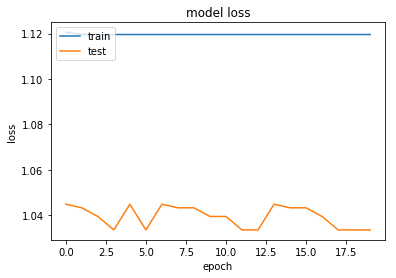

In [57]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conclusion
From the above testing results:
- Increaseing number of nodes in hidden layer improves results.
- Adding more layers improves results.
- With the same number layers, more nodes better results.
- Use linear activition in the output layer is better than sigmoid activition.

### Model 4: Single layer recurrent neural network

Train a recurrent neural network with a single layer, using a `GRU` recurrent cell. 

Look at documentation for the GRU layers in keras: https://keras.io/layers/recurrent/

You will not need a `Flatten` layer in these networks.

In [115]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM, GRU

in_out_neurons = 1  
hidden_neurons = 300

model = Sequential()
model.add(GRU(hidden_neurons, return_sequences=False,
               input_shape=(None, in_out_neurons)))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mae", optimizer="rmsprop", metrics=['accuracy']) 

In [116]:
print(model.output_shape)

(None, 1)


In [117]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 300)               271800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 272,101
Trainable params: 272,101
Non-trainable params: 0
_________________________________________________________________


In [118]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 68s 125ms/step - loss: 0.1053 - acc: 0.0000e+00 - val_loss: 0.0779 - val_acc: 0.0000e+00
Epoch 2/20
540/540 [==============================] - 66s 123ms/step - loss: 0.0668 - acc: 0.0000e+00 - val_loss: 0.0931 - val_acc: 0.0000e+00
Epoch 3/20
540/540 [==============================] - 68s 126ms/step - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.1498 - val_acc: 0.0000e+00
Epoch 4/20
540/540 [==============================] - 68s 125ms/step - loss: 0.0475 - acc: 0.0000e+00 - val_loss: 0.1990 - val_acc: 0.0000e+00
Epoch 5/20
540/540 [==============================] - 67s 124ms/step - loss: 0.0435 - acc: 0.0000e+00 - val_loss: 0.2547 - val_acc: 0.0000e+00
Epoch 6/20
540/540 [==============================] - 67s 124ms/step - loss: 0.0403 - acc: 0.0000e+00 - val_loss: 0.2582 - val_acc: 0.0000e+00
Epoch 7/20
540/540 [==============================] - 68s 125ms/step - loss: 0.0360 - acc: 0.0000e+00 - val_loss: 0.3260 - val_acc: 0.0000e+00

In [111]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM, GRU

in_out_neurons = 1  
hidden_neurons = 300

model = Sequential()
model.add(LSTM(hidden_neurons, return_sequences=False,
               input_shape=(None, in_out_neurons)))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mae", optimizer="rmsprop")  

In [112]:
print(model.output_shape)

(None, 1)


In [113]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [114]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 166s 308ms/step - loss: 0.1308 - val_loss: 0.3061
Epoch 2/20
540/540 [==============================] - 141s 262ms/step - loss: 0.0863 - val_loss: 0.2290
Epoch 3/20
540/540 [==============================] - 140s 259ms/step - loss: 0.0742 - val_loss: 0.1622
Epoch 4/20
540/540 [==============================] - 141s 261ms/step - loss: 0.0664 - val_loss: 0.1657
Epoch 5/20
540/540 [==============================] - 141s 261ms/step - loss: 0.0590 - val_loss: 0.1455
Epoch 6/20
540/540 [==============================] - 142s 263ms/step - loss: 0.0553 - val_loss: 0.1838
Epoch 7/20
540/540 [==============================] - 140s 260ms/step - loss: 0.0524 - val_loss: 0.2133
Epoch 8/20
540/540 [==============================] - 141s 262ms/step - loss: 0.0488 - val_loss: 0.4541
Epoch 9/20
540/540 [==============================] - 145s 268ms/step - loss: 0.0444 - val_loss: 0.4019
Epoch 10/20
540/540 [==============================] - 151s 280m

## Conclusion
From the above testing results:
- From the above testing results, GRU seems to fit time series better than LSTM model.

### Model 5: Single layer recurrent neural network with dropout

Train a recurrent neural network with a single layer, using a GRU recurrent cell.

Look at documentation for the GRU layers in keras: https://keras.io/layers/recurrent/

Use the `dropout` and `recurrent_dropout` arguments to implement weight dropout in the RNN. 

In [124]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU

in_out_neurons = 1  
hidden_neurons = 300

model = Sequential()
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True, input_shape=(None, in_out_neurons)))
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1))
#model.add(Dropout(0.2))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mae", optimizer="rmsprop") 

In [125]:
print(model.output_shape)

(None, 1)


In [126]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 300)         271800    
_________________________________________________________________
gru_4 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 813,001
Trainable params: 813,001
Non-trainable params: 0
_________________________________________________________________


In [127]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 178s 330ms/step - loss: 0.1912 - val_loss: 0.2245
Epoch 2/20
540/540 [==============================] - 184s 341ms/step - loss: 0.1256 - val_loss: 0.1289
Epoch 3/20
540/540 [==============================] - 176s 326ms/step - loss: 0.1146 - val_loss: 0.1349
Epoch 4/20
540/540 [==============================] - 166s 307ms/step - loss: 0.1038 - val_loss: 0.1516
Epoch 5/20
540/540 [==============================] - 168s 311ms/step - loss: 0.0871 - val_loss: 0.1436
Epoch 6/20
540/540 [==============================] - 177s 328ms/step - loss: 0.0817 - val_loss: 0.1306
Epoch 7/20
540/540 [==============================] - 168s 312ms/step - loss: 0.0764 - val_loss: 0.1462
Epoch 8/20
540/540 [==============================] - 163s 302ms/step - loss: 0.0733 - val_loss: 0.1468
Epoch 9/20
540/540 [==============================] - 169s 313ms/step - loss: 0.0704 - val_loss: 0.1737
Epoch 10/20
540/540 [==============================] - 165s 306m

## Conclusion
From the above testing results:
- From the above testing results, adding dropout and recurrent_dropout weight doesn't improve the results.

### Model 6: Deep RNN 

Train a recurrent neural network with two or more layers, with or without dropout. Here experiment with number and size of layers using validation error as a guide.

In [7]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU, LSTM
from keras import layers

in_out_neurons = 1  
hidden_neurons = 300

model = Sequential()
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True, input_shape=(None, in_out_neurons)))
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
#model.add(LSTM(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
#model.add(layers.CuDNNLSTM(hidden_neurons, return_sequences=True))
model.add(GRU(hidden_neurons))

model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mae", optimizer="rmsprop") 

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 300)         271800    
_________________________________________________________________
gru_5 (GRU)                  (None, None, 300)         540900    
_________________________________________________________________
gru_6 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,353,901
Trainable params: 1,353,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 246s 456ms/step - loss: 0.2529 - val_loss: 0.2418
Epoch 2/20
540/540 [==============================] - 246s 456ms/step - loss: 0.1452 - val_loss: 0.1597
Epoch 3/20
540/540 [==============================] - 242s 448ms/step - loss: 0.1144 - val_loss: 0.1615
Epoch 4/20
540/540 [==============================] - 224s 415ms/step - loss: 0.0949 - val_loss: 0.1898
Epoch 5/20
540/540 [==============================] - 226s 419ms/step - loss: 0.0802 - val_loss: 0.1661
Epoch 6/20
540/540 [==============================] - 227s 420ms/step - loss: 0.0727 - val_loss: 0.2017
Epoch 7/20
540/540 [==============================] - 223s 412ms/step - loss: 0.0679 - val_loss: 0.1905
Epoch 8/20
540/540 [==============================] - 230s 426ms/step - loss: 0.0626 - val_loss: 0.2164
Epoch 9/20
540/540 [==============================] - 231s 428ms/step - loss: 0.0590 - val_loss: 0.2031
Epoch 10/20
540/540 [==============================] - 231s 427m

In [10]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU, LSTM
from keras import layers

in_out_neurons = 1  
hidden_neurons = 200

model = Sequential()
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True, input_shape=(None, in_out_neurons)))
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
model.add(GRU(hidden_neurons))

model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mae", optimizer="rmsprop")  

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, None, 200)         121200    
_________________________________________________________________
gru_8 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
gru_9 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
gru_10 (GRU)                 (None, None, 200)         240600    
_________________________________________________________________
gru_11 (GRU)                 (None, 200)               240600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total para

In [12]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 213s 394ms/step - loss: 0.2489 - val_loss: 0.2198
Epoch 2/20
540/540 [==============================] - 224s 415ms/step - loss: 0.1427 - val_loss: 0.2502
Epoch 3/20
540/540 [==============================] - 319s 591ms/step - loss: 0.1201 - val_loss: 0.1859
Epoch 4/20
540/540 [==============================] - 235s 436ms/step - loss: 0.1129 - val_loss: 0.2361
Epoch 5/20
540/540 [==============================] - 196s 363ms/step - loss: 0.1063 - val_loss: 0.2522
Epoch 6/20
540/540 [==============================] - 182s 338ms/step - loss: 0.1025 - val_loss: 0.2264
Epoch 7/20
540/540 [==============================] - 185s 342ms/step - loss: 0.0862 - val_loss: 0.2026
Epoch 8/20
540/540 [==============================] - 188s 348ms/step - loss: 0.0769 - val_loss: 0.2022
Epoch 9/20
540/540 [==============================] - 186s 345ms/step - loss: 0.0709 - val_loss: 0.2004
Epoch 10/20
540/540 [==============================] - 178s 330m

In [13]:
print('Evaluating -----------')

for step in range(num_val_steps):
    X_test, y_test = next(val_gen)

    score = model.evaluate(X_test, y_test,verbose=1)
    print('Evaluation Score: ', score)

Evaluating -----------
20/20 [==============================] - 0s 10ms/step
Evaluation Score:  0.11526278406381607
20/20 [==============================] - 0s 11ms/step
Evaluation Score:  0.23357948660850525
20/20 [==============================] - 0s 12ms/step
Evaluation Score:  0.20024187862873077
20/20 [==============================] - 0s 9ms/step
Evaluation Score:  0.18725702166557312
20/20 [==============================] - 0s 9ms/step
Evaluation Score:  0.11526278406381607
20/20 [==============================] - 0s 9ms/step
Evaluation Score:  0.23357948660850525
20/20 [==============================] - 0s 12ms/step
Evaluation Score:  0.20024187862873077
20/20 [==============================] - 0s 10ms/step
Evaluation Score:  0.18725702166557312
20/20 [==============================] - 0s 14ms/step
Evaluation Score:  0.11526278406381607
20/20 [==============================] - 0s 10ms/step
Evaluation Score:  0.23357948660850525
20/20 [==============================] - 0s 8ms/st

In [45]:
import numpy as np
from sklearn.metrics import accuracy_score
from functools import reduce
import operator

print('predicting -----------')

preds = []
for step in range(num_val_steps):
    X_test, y_test = next(val_gen)
    
    y_true = y_test.tolist()

    #print(y_true)
    y_pred = model.predict(X_test)
    
    y_pred_flat = reduce(operator.iconcat, y_pred, [])
    #print(y_pred_flat)
    for i in range(len(y_true)):
        pred = (1 - y_true[i]/y_pred_flat[i])
        preds.append(abs(pred))
    #accuracy_score(y_test[0], y_pred[0])
    #print('Predictions score: ', accuracy_score(y_true, y_pred_flat))
    

nd_array = np.array(preds)
print('Predictions mean: ', nd_array.mean())

predicting -----------
Predictions mean:  0.17527205690507605


In [46]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU, LSTM
from keras import layers

in_out_neurons = 1  
hidden_neurons = 400

model = Sequential()
model.add(GRU(hidden_neurons, dropout=0.0, recurrent_dropout=0.0, return_sequences=True, input_shape=(None, in_out_neurons)))
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
model.add(GRU(hidden_neurons, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
model.add(GRU(hidden_neurons))

model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mae", optimizer="rmsprop") 

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

In [48]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU, LSTM
from keras import layers

in_out_neurons = 1  
hidden_neurons = 400
hidden_neurons_2 = 200

model = Sequential()
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True, input_shape=(None, in_out_neurons)))
model.add(GRU(hidden_neurons, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
model.add(GRU(hidden_neurons_2, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
model.add(GRU(hidden_neurons_2, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
model.add(GRU(hidden_neurons_2))

model.add(Dense(in_out_neurons, input_dim=hidden_neurons_2))  
model.add(Activation("linear"))  
model.compile(loss="mae", optimizer="rmsprop")  

In [49]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/20
540/540 [==============================] - 405s 750ms/step - loss: 0.2632 - val_loss: 0.2410
Epoch 2/20
540/540 [==============================] - 383s 710ms/step - loss: 0.1472 - val_loss: 0.1946
Epoch 3/20
540/540 [==============================] - 406s 751ms/step - loss: 0.1213 - val_loss: 0.2134
Epoch 4/20
540/540 [==============================] - 405s 750ms/step - loss: 0.1107 - val_loss: 0.2369
Epoch 5/20
540/540 [==============================] - 377s 698ms/step - loss: 0.1046 - val_loss: 0.2587
Epoch 6/20
540/540 [==============================] - 378s 700ms/step - loss: 0.0975 - val_loss: 0.2532
Epoch 7/20
540/540 [==============================] - 378s 700ms/step - loss: 0.0956 - val_loss: 0.1922
Epoch 8/20
540/540 [==============================] - 376s 696ms/step - loss: 0.1078 - val_loss: 0.2933
Epoch 9/20
540/540 [==============================] - 384s 711ms/step - loss: 0.0796 - val_loss: 0.2384
Epoch 10/20
540/540 [==============================] - 360s 666m

In [50]:
print('Evaluating -----------')

for step in range(num_val_steps):
    X_test, y_test = next(val_gen)

    score = model.evaluate(X_test, y_test,verbose=1)
    print('Evaluation Score: ', score)

Evaluating -----------
20/20 [==============================] - 0s 14ms/step
Evaluation Score:  0.14071834087371826
20/20 [==============================] - 0s 13ms/step
Evaluation Score:  0.26163217425346375
20/20 [==============================] - 0s 12ms/step
Evaluation Score:  0.21704621613025665
20/20 [==============================] - 0s 16ms/step
Evaluation Score:  0.201259583234787
20/20 [==============================] - 0s 13ms/step
Evaluation Score:  0.14071834087371826
20/20 [==============================] - 0s 18ms/step
Evaluation Score:  0.26163217425346375
20/20 [==============================] - 0s 14ms/step
Evaluation Score:  0.21704621613025665
20/20 [==============================] - 0s 16ms/step
Evaluation Score:  0.201259583234787
20/20 [==============================] - 0s 15ms/step
Evaluation Score:  0.14071834087371826
20/20 [==============================] - 0s 19ms/step
Evaluation Score:  0.26163217425346375
20/20 [==============================] - 0s 13ms/st

In [51]:
import numpy as np
from sklearn.metrics import accuracy_score
from functools import reduce
import operator

print('predicting -----------')

preds = []
for step in range(num_val_steps):
    X_test, y_test = next(val_gen)
    
    y_true = y_test.tolist()

    #print(y_true)
    y_pred = model.predict(X_test)
    
    y_pred_flat = reduce(operator.iconcat, y_pred, [])
    #print(y_pred_flat)
    for i in range(len(y_true)):
        pred = (1 - y_true[i]/y_pred_flat[i])
        preds.append(abs(pred))
    #accuracy_score(y_test[0], y_pred[0])
    #print('Predictions score: ', accuracy_score(y_true, y_pred_flat))
    

nd_array = np.array(preds)
print('Predictions mean: ', nd_array.mean())

predicting -----------
Predictions mean:  0.19179228619831998


## Conclusion

Comment on the overall performance of these models. 

- How much of an improvement did you obtain over the baseline? 
        Comparing with baseline, the evaluation score almost doubled. 
- What is the general relative performance of recurrent networks relative to flat networks? 
        Recurrent networks is relatively better than flat networks.
- What was the effect of using dropout in the RNN network? 
        I don't see that using dropout improves results.
- What was the effect of network architecture, number and size of layers, on performance? Was the effect similar in RNNs and flat networks?
        Number of neurons effect more than the size of layers. 
        The model with more number of neurons has better results.
        The model with less number of neurons tunes the results slowly at each epoch.
        The model with more number of neurons will take more time to run.
        The model with missed number of neurons and layers has better results.

Choose a final model based on your observations above and compare to the baseline model based on the median absolute error on the test set portion of the data. 